In [ ]:
# Make sure we've got the latest fastbook version
! pip install -Uqq fastbook dotenv
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 16.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 172.5 MB/s eta 0:00:0100:01

In [8]:
# Connect to MongoDB and retrieve image URLs and metadata
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv
import os

# Load the dotenv file
load_dotenv()

# Grab the MONGO_URI from local or from Kaggle
mongo_uri = os.getenv('MONGO_URI')
if not mongo_uri:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    mongo_uri = user_secrets.get_secret("MONGO_URI")

# Connect to the MongoDB client
client = MongoClient(mongo_uri)
 
# Access the database and collection
db = client['test']
collection = db['cameratrapmedias'] 
 
# Query the collection to retrieve records with image URLs, metadata, and the first index of 'relativePath'
data = list(collection.aggregate([
    {
        '$project': {
            '_id': 0,
            'publicURL': 1,
            'timestamp': 1,
            'relativePathSecond': { '$arrayElemAt': ['$relativePath', 1] },
            'relativePathLast': { '$arrayElemAt': ['$relativePath', 4]}
        }
    },
    # { '$limit': 150 }
]))
 
# Convert the data to a pandas DataFrame for exploration
df = pd.DataFrame(data)

# Export the small array to a CSV file for preview
df.to_csv('ur_test_medias.csv', index=False)
 
# Display the first few rows of the DataFrame
print(df.head())

            timestamp                                          publicURL  \
0 2024-01-27 13:33:15  https://urbanriverrangers.s3.amazonaws.com/ima...   
1 2024-01-24 18:56:50  https://urbanriverrangers.s3.amazonaws.com/ima...   
2 2024-01-24 19:01:54  https://urbanriverrangers.s3.amazonaws.com/ima...   
3 2024-01-24 19:03:05  https://urbanriverrangers.s3.amazonaws.com/ima...   
4 2024-01-24 19:04:19  https://urbanriverrangers.s3.amazonaws.com/ima...   

                        relativePathSecond  
0                   2024-01-30_prologis_02  
1  2024-01-30_Learnin_platform_camera_test  
2  2024-01-30_Learnin_platform_camera_test  
3  2024-01-30_Learnin_platform_camera_test  
4  2024-01-30_Learnin_platform_camera_test  


In [ ]:
# We are going to create a column that creates a file name to save the image

Now that we have a connection to the MongoDB server and access to the URLs, let's use the `fastbook` library to simplify image handling and prepare for model inference.

In [11]:
# Preview 4 images from the publicURL column using fastbook
from fastbook import *
from fastai.vision.widgets import *

# Create a directory to save the images
path = Path('images')
path.mkdir(exist_ok=True)

# Download and display some images where at least an animal was found - ex rat
urls = df['publicURL'][44410:44420]
for i, url in enumerate(urls):
    # Download the image
    dest = path/f'image_{i}.jpg'
    download_url(url, dest, show_progress=False) # No need to show a download bar for each one


In [12]:
# Create a list of all images that were downloaded
images = [PILImage.create(path/f'image_{i}.jpg') for i in range(10)]

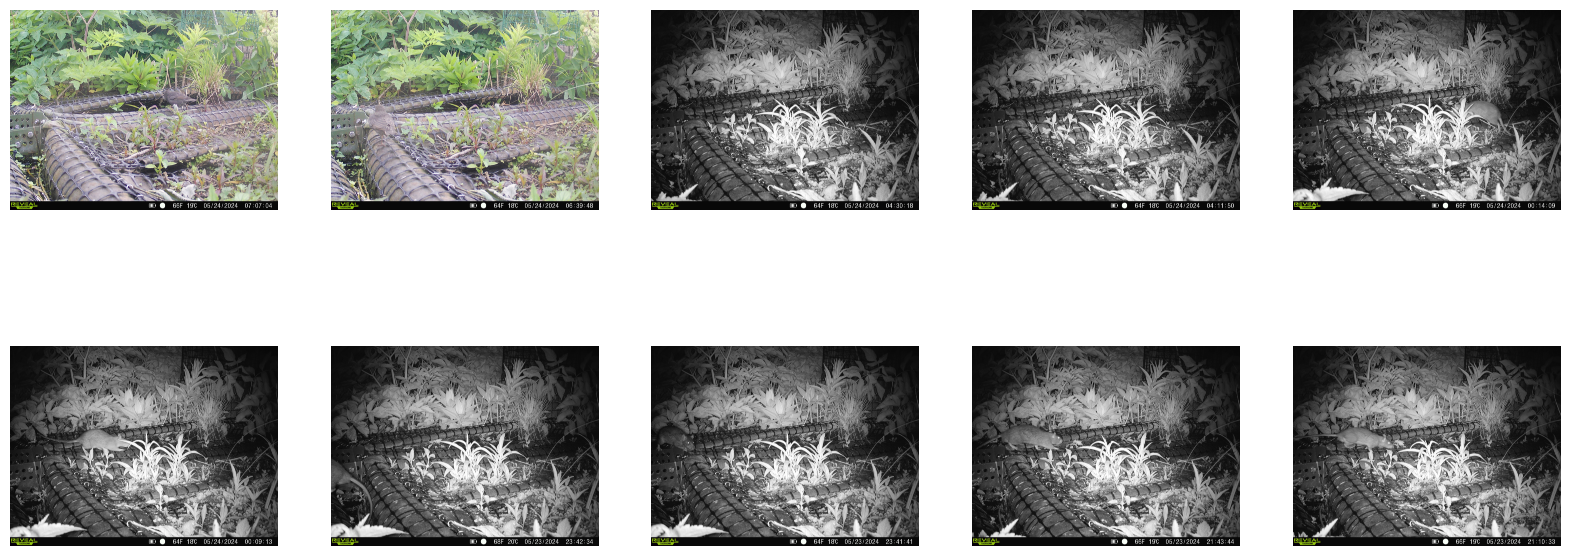

In [13]:
# Display the images using fastai utilities
%matplotlib inline
show_images(images, nrows=2, ncols=5, figsize=(20, 8))

We clearly have the ability to access the URLs and index through images - now there are two paths to take
1. Try using the full image Google speciesnet model (v4.0.1b) as is -
   - pre processing these images by vertical cropping top and bottom then scaling into right size (480x480px)


In [4]:
! pip install -Uqq speciesnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
from IPython.display import display
from IPython.display import JSON

from speciesnet import DEFAULT_MODEL
from speciesnet import draw_bboxes
from speciesnet import load_rgb_image
from speciesnet import SpeciesNet
from speciesnet import SUPPORTED_MODELS

In [6]:
def print_predictions(predictions_dict: dict) -> None:
    print("Predictions:")
    for prediction in predictions_dict["predictions"]:
        print(prediction["filepath"], "=>", prediction["prediction"])

### Download Model

In [2]:
import kagglehub
import os
import shutil

# Choose the folder we're going to download to
model_path = '/content/models'
os.makedirs(model_path, exist_ok=True)

# Download the model (it will go to a folder like /kaggle/input/...)
download_path = kagglehub.model_download('google/speciesnet/PyTorch/v4.0.1a',
                                          force_download=True)

print('Model downloaded to temporary folder: {}'.format(download_path))

# List the contents of the downloaded directory to identify the actual files/subdirectories
model_files = os.listdir(download_path)

# Copy the contents of the model file to our destination folder
for item_name in model_files:
    source_path = os.path.join(download_path, item_name)
    destination_path = os.path.join(model_path, item_name)
    if os.path.isfile(source_path):
        shutil.copy2(source_path, destination_path)
    elif os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print('{} files copied to: {}'.format(len(model_files),model_path))

Model downloaded to temporary folder: /kaggle/input/speciesnet/pytorch/v4.0.1a/1
6 files copied to: /content/models


In [10]:
print("Default SpeciesNet model:", DEFAULT_MODEL)
print("Supported SpeciesNet models:", SUPPORTED_MODELS)

Default SpeciesNet model: kaggle:google/speciesnet/pyTorch/v4.0.1a
Supported SpeciesNet models: ['kaggle:google/speciesnet/pyTorch/v4.0.1a', 'kaggle:google/speciesnet/pyTorch/v4.0.1b']


In [7]:
# Pick the model we want to use (4.0.1a)
model = SpeciesNet(model_path)

In [16]:
predictions_dict = model.predict(
    instances_dict={
        "instances": [
            {
                "filepath": "/kaggle/working/images/image_0.jpg",
                "latitude": 41.906782,
                "longitude": -87.651927,
            },
            {
                "filepath": "/kaggle/working/images/image_4.jpg",
                "latitude": 41.906782,
                "longitude": -87.651927,
            },
            {
                "filepath": "/kaggle/working/images/image_7.jpg",
                "latitude": 41.906782,
                "longitude": -87.651927,
            },
        ]
    }
)

print_predictions(predictions_dict)
display(JSON(predictions_dict))

Predictions:
/kaggle/working/images/image_0.jpg => b1352069-a39c-4a84-a949-60044271c0c1;aves;;;;;bird
/kaggle/working/images/image_4.jpg => c6d86eca-a84f-4e62-ab7c-0cbaeffda76c;mammalia;diprotodontia;potoroidae;potorous;;potorous species
/kaggle/working/images/image_7.jpg => 1f689929-883d-4dae-958c-3d57ab5b6c16;;;;;;animal


<IPython.core.display.JSON object>

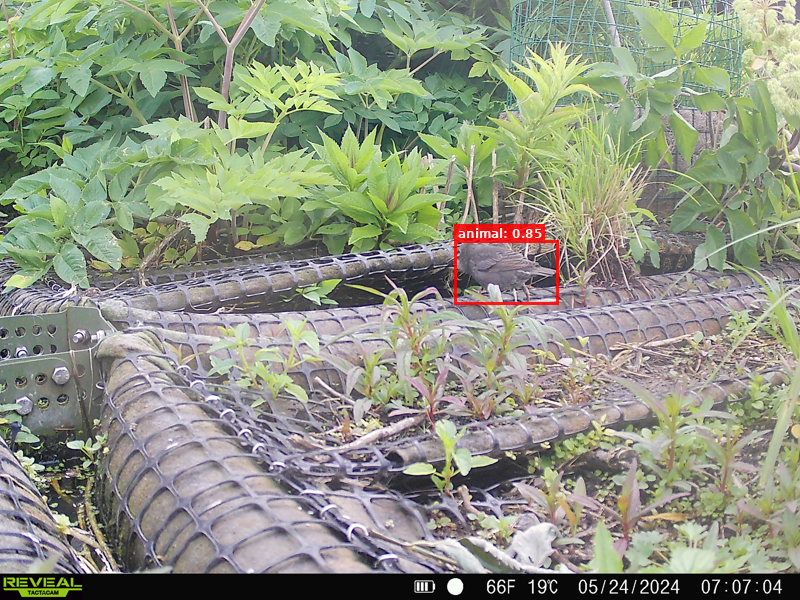

In [19]:
first_prediction_item = predictions_dict["predictions"][0]
img = load_rgb_image(first_prediction_item["filepath"])
detections = first_prediction_item["detections"]
img.thumbnail(size=(800, 800))
draw_bboxes(img, detections)